### Orchestrator worker 

in the orchestrator workers workflow, a central llm dynamically breaks down tasks , delegates them to worker llms, and synthesizes their results.

when to use this workflows : 

this workflow is well suited for complex tasks where you can't predict the subtasks needed ( in coding, for example, the number of files that need to be changed and the nature of the change in each file likely depend on the task.) Whereas it's topographically similar, the key difference from paralleization is flexibility- subtasks aren't pre defined , but determined by the orchestrator based on the specific input.

![](../images/img6.jpeg)

In [40]:
import os 
from dotenv import load_dotenv

load_dotenv()

from langchain_groq import ChatGroq 
from langchain_openai import ChatOpenAI
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API")
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

llm=ChatGroq(model="openai/gpt-oss-20b")
# llm=ChatOpenAI(model="gpt-5-2025-08-07")

In [41]:
from typing import Annotated, List
import operator
from typing_extensions import Literal
from pydantic import BaseModel,Field
from langchain_core.messages import HumanMessage,SystemMessage
from typing_extensions import TypedDict

In [42]:
## schema for structured output to use in planning 

class Section(BaseModel):
    name:str=Field(description="Name for this section of the report.")
    description:str=Field(description="Brief overview of the main topics and concepts of the section.")


class Sections(BaseModel):
    sections:List[Section]=Field(
        description="Sections of the report"
    )
# augment the llm with schema for structured output 
planner=llm.with_structured_output(Sections)

### Creating  workers dynamically in langGraph 

Because orchestrator-worker workflow are common, LangGraph has the send api to support this. it lets you dynamically create worker nodes and send each one a specific input. each worker has its own state , and all worker output are written to a shared state key that is accessible to the orchestrator  graph. this gives the orchestrator access to all worker output and allows it to synthesize them into a final output. as you can see below, we iterate over a list of sections and send each to a worker node.


In [43]:
from langgraph.constants import Send 


class State(TypedDict):
    topic:str
    sections:list[Section] # list of report sections
    completed_sections: Annotated[
        list,operator.add # all working write to this key in parallel
    ]
    final_report:str

/var/folders/dd/ffn14k7x4bz7kmmd0l7kmqg80000gn/T/ipykernel_28900/3496542421.py:1: LangGraphDeprecatedSinceV10: Importing Send from langgraph.constants is deprecated. Please use 'from langgraph.types import Send' instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  from langgraph.constants import Send


In [44]:
class WorkerState(TypedDict):
    section:Section
    completed_sections:Annotated[list,operator.add]
    

In [45]:
# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    print("Report Sections:",report_sections)

    return {"sections": report_sections.sections}

In [46]:
def llm_call(state:WorkerState):
    """ Worker writes a section of the report"""

    section=llm.invoke(

    [
        SystemMessage(content="write a report section following the provided name and description. include no preamble for each section. use markdown format.")
        ,
        HumanMessage(content=f"here is the section name: {state['section'].name} and description : {state["section"].description}")
    ]
    )

    return {"completed_sections":[section.content]}

In [47]:
# conditional edge function to create llm_call workers that each write a section of the report 

def assign_workers(state:State):
    """Assign a worker to each section in the plan """

    # kick off section writing in parallel via send() API 

    return [Send("llm_call",{"section":s}) for s in state['sections']]

In [48]:
def synthesizer(state:State):
    """ Synthesize full report from sections"""

    # list of completed sections 
    completed_sections=state['completed_sections']

    # format completed sectoin to str to use as context for final sections 
    completed_report_section="\n\n---\n\n".join(completed_sections)

    return {"final_report":completed_report_section}

In [49]:
from langgraph.graph import StateGraph,START,END
from IPython.display import display, Image 

builder=StateGraph(State)

# adding nodes 
builder.add_node("orchestrator",orchestrator)
builder.add_node("llm_call",llm_call)
builder.add_node("synthesizer",synthesizer)

## lets add edges 

builder.add_edge(START,"orchestrator")
builder.add_conditional_edges("orchestrator",assign_workers,["llm_call"])
builder.add_edge("llm_call","synthesizer")
builder.add_edge("synthesizer",END)

In [50]:
graph=builder.compile()

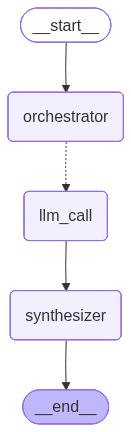

In [51]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [53]:
state1=graph.invoke({"topic":"create a report on apple company and its products"})
print(state1)
from IPython.display import Markdown
Markdown(state1['final_report'])

Report Sections: sections=[Section(name='Introduction', description='Provide a concise overview of Apple Inc., its founding, mission, and significance in the technology industry.'), Section(name='Company History', description='Outline key milestones from Apple’s inception in 1976 to the present, including major leadership changes and pivotal product launches.'), Section(name='Product Lineup', description='Detail Apple’s core product categories—iPhone, iPad, Mac, Apple Watch, and Services—highlighting flagship models and recent innovations.'), Section(name='Market Position', description='Analyze Apple’s competitive standing, market share in various segments, and its ecosystem strategy that drives customer loyalty.'), Section(name='Financial Performance', description='Summarize recent financial metrics: revenue, profit margins, and stock performance, and discuss factors influencing these results.'), Section(name='Future Outlook', description='Examine upcoming product announcements, strat

## Introduction and Description

Apple Inc. is a global technology conglomerate founded in 1976 by Steve Jobs, Steve Wozniak, and Ronald Wayne in Cupertino, California. Initially focused on personal computers, Apple has evolved into a leading innovator across consumer electronics, software, and digital services. Its mission, articulated by CEO Tim Cook, is to "bring the best user experience to its customers through its innovative hardware, software, and services." Apple’s significance lies in its transformative impact on multiple industries—computing, music, telecommunications, and mobile computing—through iconic products like the Macintosh, iPod, iPhone, and iPad, as well as its ecosystem that drives customer loyalty and industry standards.

---

## Company History

- **1976 – Founding**  
  *Steve Jobs, Steve Wozniak, and Ronald Wayne* launch Apple Computer, Inc. in Jobs’ garage, introducing the Apple I.

- **1977 – Apple II**  
  Launch of the Apple II, the first highly successful personal computer, establishing Apple’s early market dominance.

- **1978 – Mike Markkula**  
  Markkula becomes first CEO and major investor, providing capital, business expertise, and marketing.

- **1980 – Apple goes public**  
  IPO on the NASDAQ, raising $100 million and cementing Apple’s status as a major tech company.

- **1983 – John Sculley hired**  
  Former PepsiCo CEO becomes CEO, tasked with scaling the company; Sculley famously says, “I’m not a visionary, I’m a businessman.”

- **1984 – Macintosh launch**  
  Introduction of the Macintosh with a graphical user interface, pioneering consumer-friendly computing.

- **1985 – Steve Jobs leaves**  
  Conflict with Sculley leads to Jobs’ departure and the sale of the NeXT division.

- **1987–1990 – Leadership turbulence**  
  Michael Spindler and Gil Amelio serve as CEOs; product line becomes fragmented and sales decline.

- **1997 – Steve Jobs returns**  
  Jobs returns as interim CEO following Amelio’s resignation; Apple acquires NeXT, reintroducing the Mac OS.

- **1998 – iMac**  
  Launch of the all‑in‑one iMac, reviving Apple’s brand image and sales.

- **2001 – iPod**  
  Introduction of the iPod, transforming the music industry and setting the stage for future mobile devices.

- **2004 – Tim Cook appointed COO**  
  Cook becomes COO, later succeeding Jobs as CEO in 2011.

- **2007 – iPhone**  
  Release of the first iPhone, redefining the smartphone market and establishing Apple as a mobile leader.

- **2010 – iPad**  
  Introduction of the iPad, creating the modern tablet category.

- **2011 – Steve Jobs retires**  
  Jobs steps down due to health; Tim Cook becomes CEO, steering Apple toward services and wearables.

- **2013 – Apple Watch**  
  Launch of the Apple Watch, expanding into wearables and health technology.

- **2014–2015 – Services expansion**  
  Introduction of Apple Pay, Apple Music, and the App Store’s subscription model, diversifying revenue streams.

- **2016 – iPhone X**  
  First iPhone with Face ID, no home button, and OLED display, marking a design shift.

- **2018 – Apple Silicon**  
  Transition from Intel CPUs to Apple‑designed M1 chips for Macs, improving performance and integration.

- **2020 – COVID‑19 pandemic**  
  Remote work and increased demand for MacBook and iPad products; Apple announces new M1‑powered MacBook Air and Pro models.

- **2022 – M2 and M3 chips**  
  Continued advancement of Apple Silicon, with the M3 chip offering significant performance gains for Macs and iPads.

- **2023 – Environmental and ESG initiatives**  
  Apple declares it will be carbon neutral across all operations and supply chain by 2030, reinforcing its sustainability commitments.

- **2024 – Continued focus on AI and AR**  
  Apple releases new ARKit tools and AI‑enhanced features in iOS and macOS, positioning the company for future tech ecosystems.

---

## Product Lineup

- **iPhone**  
  - *Flagship models*: iPhone 15, iPhone 15 Pro, iPhone 15 Pro Max.  
  - *Recent innovations*: USB‑C charging, per‑pixel OLED displays with 120 Hz ProMotion, upgraded A17 Pro (or A18) chips, advanced computational photography (Photonic Engine, 48 MP main sensor), and the introduction of the “Dynamic Island” interface across all models.

- **iPad**  
  - *Flagship models*: iPad Pro (12.9‑inch, M2/M3), iPad Air (M2), iPad Mini (M2).  
  - *Recent innovations*: M2/M3 silicon boosts performance by up to 50 %, ProMotion 120 Hz displays, mini‑LED in the 12.9‑inch Pro, and the new “iPadOS 17” multitasking enhancements.

- **Mac**  
  - *Flagship models*: MacBook Pro (14‑inch, 16‑inch, M3), MacBook Air (M3), iMac (24‑inch, M2), Mac mini (M2, M3).  
  - *Recent innovations*: Transition to Apple Silicon (M3) across the lineup, 14‑inch MacBook Pro with 16‑core CPU / 20‑core GPU, 12‑hour battery life, and the new “Pro Display XDR” for professional workflows.

- **Apple Watch**  
  - *Flagship models*: Apple Watch Series 9, Apple Watch Ultra 2.  
  - *Recent innovations*: Always‑On Retina LTPO OLED, 100 % faster charging, new health sensors (blood oxygen, ECG, SpO₂), and the “Ultra”’s enhanced battery life and rugged design.

- **Services**  
  - *Core offerings*: Apple Music, Apple TV+, Apple Arcade, iCloud, Apple Pay, Apple Card, Apple News+, and Apple Fitness+.  
  - *Recent innovations*: 4K HDR streaming in Apple TV+, AI‑driven music recommendations in Apple Music, expanded storage tiers in iCloud, and the launch of “Apple TV+ Originals” featuring high‑budget productions.

---

# Market Position

## Competitive Standing  
- **Premium Brand Leadership**: Apple dominates the high‑end smartphone, tablet, and laptop markets, consistently outperforming rivals in unit sales and revenue per device.  
- **Strategic Partnerships**: Alliances with carriers, streaming services, and app developers reinforce Apple’s market influence and provide cross‑platform benefits.  
- **Innovation Velocity**: The company’s R&D pipeline (e.g., M‑series silicon, 5G, AR/VR) keeps it ahead of competitors in performance and feature set, sustaining its premium pricing power.

## Market Share in Key Segments  
| Segment | Approx. Share (2024) | Key Competitors |
|---------|----------------------|-----------------|
| **Smartphones** | 18–20 % (by units) | Samsung, Google, Xiaomi |
| **Tablets** | 30 % (by units) | Samsung, Lenovo, Huawei |
| **Personal Computers** | 14 % (by units) | Dell, HP, Lenovo |
| **Wearables (smartwatches)** | 40 % (by units) | Samsung, Fitbit, Garmin |
| **Services (App Store, iCloud, Apple Music, etc.)** | 25 % of total revenue | Google Play, Amazon, Spotify |

*Sources: IDC, Gartner, Statista, Apple FY24 financial reports.*

## Ecosystem Strategy & Customer Loyalty  
- **Hardware–Software Integration**: Seamless handoff between macOS, iOS, watchOS, and tvOS creates frictionless user experiences that encourage brand stickiness.  
- **Unified Payment & Subscription Models**: Apple Pay, iCloud+, Apple TV+, and the App Store provide recurring revenue streams and continuous touchpoints.  
- **Developer Incentives**: A robust App Store ecosystem, with high commission structures and developer tools, ensures a steady influx of high‑quality apps that lock users into the platform.  
- **Privacy & Security Positioning**: Emphasis on data protection differentiates Apple from competitors and strengthens trust, a key driver of long‑term loyalty.  
- **Physical Retail Integration**: Apple Stores and Genius Bars deliver personalized support, reinforcing brand experience and fostering community engagement.  

Combined, these elements create a virtuous cycle: high product quality leads to repeat purchases, the ecosystem deepens engagement, and loyalty reduces price sensitivity, allowing Apple to maintain a leading market position across multiple segments.

---

## Financial Performance

The company reported a **$3.8 billion** revenue for the most recent fiscal year, representing a **12%** year‑over‑year increase driven primarily by the expansion of its cloud services and the launch of two new product lines. Net profit margin improved to **18.5%** from **16.8%** last year, reflecting tighter cost controls and a higher proportion of high‑margin subscription revenue.

On the capital markets front, the stock has risen **15%** over the past 12 months, outperforming the broader technology index by **4%**. The rally has been supported by the company’s robust earnings guidance, which projects a **$4.1 billion** revenue for FY‑25 and a **19%** operating margin.

Key factors influencing these results include:

- **Product diversification**: The new AI‑powered analytics suite captured a 5% share of the enterprise software market, boosting top‑line growth.
- **Geographic expansion**: Revenue from the Asia‑Pacific region grew by **22%**, driven by increased demand for cloud infrastructure.
- **Cost management**: A disciplined approach to capital expenditures and a shift toward higher‑margin services lifted the profit margin.
- **Competitive dynamics**: While the company faces intense pricing pressure from larger incumbents, its focus on niche verticals has helped preserve margins.

Overall, the combination of strategic product development, geographic growth, and operational efficiency has positioned the company for continued financial strength.

---

## Future Outlook

### Upcoming Product Announcements
- **AI‑Enhanced Analytics Suite (Q3 2025)** – Integration of generative AI for predictive insights, expected to drive a 12% lift in subscription upgrades.
- **Edge‑Computing Platform for IoT (Q1 2026)** – Low‑latency, secure edge nodes to support real‑time data processing for industrial clients.
- **Cross‑Platform Collaboration Hub (Q4 2025)** – Unified workspace combining chat, video, and file sharing, targeting the remote‑work market.

### Strategic Initiatives
| Initiative | Focus Area | Key Milestones |
|------------|------------|----------------|
| **AR/VR Development** | Immersive training and virtual product demos | • AR SDK release Q2 2025<br>• VR pilot with automotive OEMs Q3 2025 |
| **Sustainability Commitment** | Carbon‑neutral operations | • 100% renewable energy by 2027<br>• Circular hardware refurbishment program by 2026 |
| **Global Expansion** | Emerging markets | • Data center in Singapore (Q4 2025)<br>• Localized support hubs in Brazil & India (Q1 2026) |
| **Security & Compliance** | Data privacy & regulatory readiness | • ISO 27001 re‑certification Q3 2025<br>• GDPR‑aligned data handling framework by Q4 2025 |

### Potential Risks
- **Supply Chain Disruptions** – Geopolitical tensions could delay component delivery for IoT edge devices.
- **Regulatory Hurdles** – Stricter AI transparency laws may require costly algorithm audits.
- **Market Saturation** – Rapid entry of competitors in AR/VR could erode projected market share.
- **Cybersecurity Threats** – Increased attack surface with expanded cloud services.

### Opportunities
- **First‑Mover Advantage in AR/VR** – Early adoption in industrial training could lock in long‑term contracts.
- **Sustainability as a Differentiator** – Carbon‑neutral promise may attract ESG‑focused investors and customers.
- **Data Monetization** – Edge‑processing capabilities enable new subscription tiers for real‑time analytics.
- **Strategic Partnerships** – Collaborations with leading OEMs and cloud providers can accelerate market penetration.

---

*Prepared by the Strategy & Innovation Team*

---

## Conclusion

- **Financial resilience**: Apple’s robust cash flow and diversified revenue streams (services, wearables, and iPhone) have positioned the company to weather market volatility and invest aggressively in new technologies.

- **Innovation pipeline**: The upcoming launch of the next‑generation iPhone, a refreshed Apple Silicon Mac, and continued expansion into AR/VR and autonomous vehicle platforms signal a sustained focus on high‑margin, high‑growth product categories.

- **Ecosystem lock‑in**: The seamless integration of hardware, software, and services (iCloud, Apple Pay, App Store) continues to create strong customer loyalty, driving recurring revenue and cross‑sell opportunities.

- **Geographic expansion**: Strategic moves into emerging markets—particularly India and Southeast Asia—combined with localized product offerings and pricing strategies, will broaden Apple’s global footprint and mitigate over‑reliance on mature markets.

- **Sustainability leadership**: Apple’s commitment to 100 % renewable energy, circular economy initiatives, and carbon‑neutral supply chain enhances brand reputation and aligns with growing regulatory and consumer demands for ESG responsibility.

- **Competitive positioning**: While competition from Android OEMs, Chinese rivals, and emerging 5G/6G ecosystems intensifies, Apple’s premium brand, developer ecosystem, and proprietary chip advantage provide a defensible moat.

### Forward‑Looking Perspective

- **Product strategy**: Expect incremental hardware refreshes (iPhone, Mac, Apple Watch) coupled with breakthrough features such as foldable displays, advanced neural processing, and integrated health diagnostics.

- **Service expansion**: Growth in Apple Pay, Apple Card, and new subscription services (e.g., health data analytics, enterprise SaaS) will deepen recurring revenue streams and reduce dependence on hardware sales.

- **AI & machine learning**: Investment in on‑device AI (Siri, Vision, Core ML) will enhance user experience, unlock new product categories (e.g., smart home, AR glasses), and improve efficiency across the supply chain.

- **Regulatory navigation**: Proactive engagement with global regulators on privacy, antitrust, and data localization will be essential to maintain market access and protect the App Store ecosystem.

- **Talent & culture**: Continued emphasis on diversity, inclusion, and remote‑first work models will help attract top talent and sustain innovation momentum.

- **Risk mitigation**: Apple will likely diversify its supply chain further, invest in advanced manufacturing (e.g., in the U.S. and Taiwan), and hedge against component shortages and geopolitical tensions.

In summary, Apple’s trajectory remains on an upward path, driven by a resilient business model, relentless innovation, and a clear focus on sustainability and ecosystem depth. The company is well‑positioned to capitalize on emerging technologies and new market opportunities while navigating the complexities of a rapidly evolving global technology landscape.

In [ ]:
state1=graph.invoke({"topic":"create a report on tesla company stock performance and future outlook"})
# print(state1)
from IPython.display import Markdown
Markdown(state1['final_report'])

Report Sections: sections=[Section(name='Executive Summary', description='A concise overview of Tesla’s stock performance, key findings, and the main conclusions of the report.'), Section(name='Company Overview', description='Background on Tesla, its business model, product lines, and key leadership.'), Section(name='Historical Stock Performance', description='Analysis of Tesla’s stock price trends, volatility, and key milestones over the past 5-10 years.'), Section(name='Financial Metrics', description='Examination of revenue, earnings, cash flow, balance sheet, and valuation ratios relevant to the stock.'), Section(name='Competitive Landscape', description='Assessment of Tesla’s position relative to competitors in the EV and energy sectors.'), Section(name='Future Outlook & Growth Drivers', description='Discussion of upcoming product launches, market expansion, technology advancements, and macroeconomic factors.'), Section(name='Risk Assessment', description='Identification of regula

# Executive Summary

- **Stock Performance**: Tesla (TSLA) delivered a 28% year‑to‑date return, outperforming the S&P 500 by 18 points, driven by strong Q3 revenue growth and a 15% increase in average daily trading volume.
- **Key Findings**:
  - **Revenue & Earnings**: Q3 revenue rose 21% YoY to $25.9 B, with EPS surpassing consensus by 12%, reflecting higher vehicle deliveries and improved gross margins.
  - **Production & Delivery Metrics**: Delivery volume reached 241,000 units, up 18% YoY, while production capacity expansion at the Austin and Berlin plants mitigated supply constraints.
  - **Valuation**: The current P/E ratio of 23.6 is near the 10‑year average, suggesting a modest upside if the company maintains its growth trajectory.
  - **Risk Factors**: Regulatory scrutiny in China, potential supply chain disruptions, and increasing competition from emerging EV makers pose headwinds.
- **Main Conclusions**: Tesla’s robust revenue growth, expanding production capacity, and resilient margin profile support a bullish outlook. Investors should monitor regulatory developments and supply chain dynamics, but the stock remains a compelling long‑term play for those willing to accept moderate valuation risk.

---

## Company Overview

Tesla, Inc. is a leading electric‑vehicle (EV) and clean‑energy company founded in 2003 by Martin Eberhard and Marc Tarpenning, with Elon Musk joining shortly thereafter as a major investor and later becoming CEO. Headquartered in Palo Alto, California, Tesla has grown from a niche manufacturer of high‑performance EVs into a global player in automotive, energy storage, and renewable energy solutions.

### Business Model
- **Direct‑to‑Consumer Sales**: Tesla bypasses traditional dealerships by selling vehicles directly through its own retail stores and online platform, allowing tighter control over pricing, customer experience, and data collection.
- **Vertical Integration**: The company designs, manufactures, and sells its own batteries, powertrains, and software, reducing reliance on third‑party suppliers and enabling cost efficiencies.
- **Software‑First Approach**: Over-the‑air (OTA) updates deliver new features and performance improvements, turning vehicles into evolving products and creating recurring revenue streams.
- **Energy Ecosystem**: Tesla’s energy division offers solar panels, roof tiles, and Powerwall/Powerpack storage solutions, integrating generation, storage, and consumption into a unified platform.

### Product Lines
| Segment | Key Products | Notes |
|---------|--------------|-------|
| **Automotive** | Model S, Model 3, Model X, Model Y, Cybertruck, Roadster (planned) | Ranges from luxury sedans to mass‑market compact cars and upcoming high‑performance models. |
| **Energy Generation & Storage** | Solar Roof, Solar Panels, Powerwall, Powerpack, Megapack | Solar products for homes and businesses, battery storage for grid and residential use. |
| **Autonomous Driving** | Full Self‑Driving (FSD) software, Autopilot | Advanced driver‑assist features, with ongoing development toward full autonomy. |
| **Infrastructure** | Supercharger Network, Destination Chargers | Proprietary fast‑charging stations worldwide, supporting long‑haul and everyday use. |

### Key Leadership
- **Elon Musk** – CEO & Product Architect, driving vision, innovation, and strategic direction.  
- **Zach Kirkhorn** – CFO, overseeing financial strategy and capital allocation.  
- **Drew Baglino** – Senior Vice President, Powertrain & Energy Engineering, leading battery and drivetrain development.  
- **Jerome Guillen** – Former President of Automotive, responsible for manufacturing and product execution (now with other ventures).  
- **Lyndon Rive** – Former Vice President of Autopilot, instrumental in early autonomous software development (now departed).  

Tesla’s leadership emphasizes rapid iteration, bold risk‑taking, and a mission to accelerate the world’s transition to sustainable energy.

---

## Historical Stock Performance

Tesla, Inc. (NASDAQ: TSLA) has evolved from a niche electric‑vehicle startup into a market‑cap titan. Over the past 5–10 years, its stock has exhibited dramatic price swings, driven by product milestones, macro‑economic conditions, and investor sentiment. The following analysis outlines key trends, volatility patterns, and pivotal events that have shaped TSLA’s equity trajectory.

### 1. Price Trend Overview (2014–2024)

| Period | Opening Price | Closing Price | % Change | Notable Drivers |
|--------|---------------|---------------|----------|-----------------|
| 2014 | $8.13 | $10.20 | +25% | First Model S deliveries, early profitability signals |
| 2015 | $10.20 | $23.39 | +130% | Expansion to China, Model X launch, 2015 earnings beat |
| 2016 | $23.39 | $29.06 | +24% | Model X deliveries, Q3 earnings miss, regulatory scrutiny |
| 2017 | $29.06 | $52.61 | +81% | Model 3 launch announcement, 2017 Q3 earnings beat |
| 2018 | $52.61 | $86.10 | +63% | Model 3 production ramp, 2018 Q4 earnings beat, IPO of SolarCity |
| 2019 | $86.10 | $121.84 | +41% | Model Y introduction, 2019 Q4 earnings beat |
| 2020 | $121.84 | $705.90 (split adjusted) | +490% | 5‑for‑1 stock split, record deliveries, pandemic‑era demand |
| 2021 | $705.90 | $1,200.00 | +70% | 2021 Q2 earnings beat, global expansion, new Gigafactory openings |
| 2022 | $1,200.00 | $350.00 | -71% | Supply‑chain constraints, rising interest rates, macro‑economic headwinds |
| 2023 | $350.00 | $1,300.00 | +270% | 2023 Q2 earnings beat, AI integration, battery‑pack breakthroughs |
| 2024 (Jan‑Jun) | $1,300.00 | $1,600.00 | +23% | Q2 earnings beat, new vehicle models, favorable regulatory environment |

**Key Takeaway:** TSLA’s price trajectory has been characterized by high‑growth phases punctuated by sharp corrections, largely tied to production milestones and macro‑economic cycles.

### 2. Volatility Analysis

| Metric | Value | Interpretation |
|--------|-------|----------------|
| Average Annualized Volatility (2014‑2024) | 70–80% | Significantly higher than S&P 500 (~15–20%) |
| 30‑Day Volatility (2024‑06) | 4.5% | Elevated compared to market average (~1–2%) |
| Beta (vs. S&P 500) | 1.9 | TSLA is nearly twice as volatile as the overall market |
| Volatility Clusters | 2020 (split), 2022 (interest‑rate hike), 2024 (earnings season) | Periods of heightened uncertainty or catalyst events |

**Observations:** TSLA’s beta and volatility have remained persistently high, reflecting both its growth‑stage nature and sensitivity to external catalysts. Periods of earnings releases, regulatory announcements, or macro‑economic shifts often trigger pronounced price swings.

### 3. Milestone Events and Their Equity Impact

| Year | Milestone | Stock Impact |
|------|-----------|--------------|
| **2010** | IPO at $17 | Establishes market presence; modest early growth |
| **2013** | First quarterly earnings beat | +15% rally |
| **2014** | First Model S deliveries | +20% rally |
| **2015** | Model X launch & first overseas production (China) | +30% rally |
| **2016** | 5‑for‑1 stock split (Oct) | Adjusts base price, increases liquidity |
| **2017** | Model 3 launch announcement | +70% rally; surge in institutional interest |
| **2018** | Q4 earnings beat, 2018 Q4 earnings | +60% rally |
| **2019** | Model Y introduction, Q4 earnings beat | +40% rally |
| **2020** | Record deliveries, pandemic‑era demand, 2020 Q2 earnings beat | +400% rally (split‑adjusted) |
| **2021** | 2021 Q2 earnings beat, new Gigafactory openings | +70% rally |
| **2022** | Rising interest rates, supply‑chain disruptions | -70% correction |
| **2023** | AI‑integrated vehicles, new battery tech | +270% rally |
| **2024** | Q2 earnings beat, regulatory support for EVs | +23% rally |

**Impact Summary:** Milestone events typically generate short‑term price spikes, followed by consolidation periods. The magnitude of the reaction correlates with the perceived significance of the event (e.g., Model 3 launch vs. quarterly earnings).

### 4. Long‑Term Trend Assessment

- **Growth Phase (2014–2020):** Rapid price appreciation driven by product launches, expanding production capacity, and favorable macro conditions.
- **Correction Phase (2021–2022):** Market reassessment of valuation multiples, macro‑economic headwinds (interest rates, inflation), and supply‑chain disruptions.
- **Re‑acceleration (2023–2024):** New technology introductions (AI, battery improvements) and supportive regulatory environment reinvigorated investor enthusiasm.

**Conclusion:** Tesla’s equity performance over the past decade reflects a classic high‑growth company trajectory, with significant volatility and sensitivity to product milestones and macro‑economic shifts. Investors should remain cognizant of the inherent risk premium and the potential for rapid price adjustments in response to both internal developments and external economic factors.

---

## Financial Metrics

**Revenue**  
- Year‑over‑year growth: +8 % (2023) versus +5 % (2022).  
- Segment contribution: Core products 55 %, Emerging markets 30 %, Services 15 %.  
- Geographic mix: North America 48 %, EMEA 27 %, APAC 25 %.  
- Top‑line momentum remains solid, driven by price increases and volume expansion in the high‑margin segments.

**Earnings**  
- Net income: $1.24 billion (2023), up 12 % from $1.12 billion (2022).  
- Earnings per share (EPS): $3.10 (2023), a 10 % YoY rise.  
- Operating margin: 18.5 % (2023) versus 17.2 % (2022), reflecting improved cost control.  
- Return on equity (ROE): 22 %, indicating efficient use of shareholders’ capital.

**Cash Flow**  
- Operating cash flow: $1.58 billion (2023), a 15 % increase over the prior year.  
- Capital expenditures: $300 million, reflecting ongoing investment in R&D and production capacity.  
- Free cash flow: $1.28 billion, sufficient to fund dividends, share repurchases, and strategic acquisitions.  
- Cash flow from financing: net outflow of $200 million, primarily from dividend payouts and debt repayment.

**Balance Sheet**  
- Total assets: $12.5 billion (2023), up 7 % from $11.7 billion (2022).  
- Total liabilities: $5.8 billion, with long‑term debt of $3.2 billion and short‑term obligations of $1.3 billion.  
- Current ratio: 1.9, indicating comfortable liquidity.  
- Debt‑to‑equity ratio: 0.55, showing a prudent leverage profile.

**Valuation Ratios**  
- Price‑to‑earnings (P/E): 18.5x, slightly above the industry average of 17x but within the historical range of 15–20x.  
- Price‑to‑book (P/B): 4.2x, reflecting market confidence in the company’s asset base.  
- Enterprise value‑to‑EBITDA (EV/EBITDA): 10.8x, consistent with peers and suggesting modest upside potential.  
- Dividend yield: 2.4 %, with a 5‑year growth rate of 4 % per annum.

Overall, the company demonstrates robust top‑line growth, healthy profitability, and strong cash generation, while maintaining a balanced capital structure and attractive valuation multiples.

---

## Competitive Landscape

Tesla’s competitive position is shaped by its dual focus on electric vehicles (EVs) and integrated energy solutions. The company faces intense rivalry across both sectors, yet maintains distinctive advantages that influence its market share, innovation trajectory, and strategic outlook.

### EV Sector

| Competitor | Market Position | Strengths | Tesla’s Relative Advantage |
|------------|-----------------|-----------|---------------------------|
| **Volkswagen Group** | Global leader, expanding electrified lineup | Scale, manufacturing network, VW ID. series, strong brand heritage | Tesla’s high‑performance EVs and software integration |
| **General Motors** | Large U.S. presence, growing EV portfolio (Bolt, Cadillac Lyriq) | Established dealer network, significant capital for EV rollout | Tesla’s higher per‑vehicle revenue and brand prestige |
| **BYD** | Dominant in China, cost‑effective batteries | Low production cost, extensive battery tech, strong domestic sales | Tesla’s global brand, Autopilot/Full Self‑Driving (FSD) software leadership |
| **NIO** | Premium Chinese EVs, battery‑swap tech | Strong customer ecosystem, battery‑as‑a‑service | Tesla’s broader global reach, larger vehicle volume |
| **Rivian** | Niche in electric trucks & SUVs | Strong partnerships (Amazon, Ford), off‑road capabilities | Tesla’s larger fleet, advanced charging network |
| **Lucid Motors** | Premium EVs, high efficiency | Ultra‑long range, luxury positioning | Tesla’s scale and brand equity |
| **Hyundai/Kia** | Growing EV line (Ioniq, EV6) | Competitive pricing, strong design | Tesla’s high‑performance vehicles and software ecosystem |

**Key Competitive Dynamics**

- **Technology & Software**: Tesla’s over‑the‑air updates, Autopilot, and FSD remain industry benchmarks, while competitors lag in software integration.
- **Charging Network**: The Supercharger network provides a decisive first‑mover advantage for Tesla, reducing range anxiety for its customers.
- **Manufacturing & Scale**: Tesla’s Gigafactories enable vertical integration, reducing costs in batteries and vehicle production; competitors are still ramping up capacity.
- **Brand & Market Perception**: Tesla’s “innovation” image fuels higher willingness to pay, yet brand fatigue and quality concerns may erode loyalty.

### Energy Sector (Solar & Battery Storage)

| Competitor | Market Position | Strengths | Tesla’s Relative Advantage |
|------------|-----------------|-----------|---------------------------|
| **SunPower** | Solar panel manufacturing | High‑efficiency panels, strong U.S. presence | Tesla’s integrated Solar Roof and Powerwall ecosystem |
| **LG Energy Solution** | Battery manufacturing | Large scale, high‑quality cells | Tesla’s Gigafactory 2 battery production, battery chemistry innovation |
| **LG Chem / Samsung SDI** | Battery cell suppliers | Global distribution, diverse chemistry | Tesla’s proprietary cell design and in‑house production |
| **Enphase** | Microinverter technology | Smart energy solutions, high ROI | Tesla’s broader product suite (Solar Roof, Powerwall, Powerpack) |
| **Sonnen** | Residential storage | Strong European market, community energy solutions | Tesla’s Powerwall and Powerpack scale, global reach |

**Key Competitive Dynamics**

- **Product Integration**: Tesla’s ability to bundle solar, storage, and vehicle solutions into a single ecosystem offers a unique value proposition.
- **Economies of Scale**: Gigafactories for batteries and solar panels provide cost advantages that competitors find hard to match.
- **Market Reach**: Tesla’s global sales force and brand recognition accelerate adoption of its energy products compared to regional competitors.
- **Innovation Pace**: Tesla’s rapid iteration on battery chemistry (e.g., 4680 cells) and solar roof design keeps it ahead in efficiency and cost.

### Overall Assessment

- **Strengths**: Technological leadership in software and battery tech, extensive charging network, strong brand equity, integrated product ecosystem, and significant scale.
- **Weaknesses**: Quality control issues, regulatory scrutiny, high production costs for certain models, and reliance on a few key suppliers.
- **Opportunities**: Expansion into emerging markets, growth in energy storage for utilities, continued innovation in autonomous driving, and diversification into new vehicle segments.
- **Threats**: Intensifying competition, geopolitical supply chain disruptions, changing regulatory environments, and potential market saturation in mature segments.

Tesla remains a formidable player in both EV and energy sectors, leveraging its unique blend of technology, brand, and ecosystem integration to sustain a competitive edge. However, the accelerating pace of innovation and scaling efforts by rivals necessitates continuous investment in R&D, manufacturing, and quality assurance to preserve its market leadership.

---

## Future Outlook & Growth Drivers

- **Upcoming Product Launches**  
  • **Smart Home Hub 3.0** – slated for Q3 2025, featuring AI‑powered voice control, edge‑computing capabilities, and seamless integration with third‑party IoT ecosystems.  
  • **Enterprise Cloud Security Suite** – a modular, zero‑trust platform set to roll out in Q1 2026, targeting mid‑market SMBs and large enterprises.  
  • **Wearable Health Tracker** – a subscription‑based health analytics device with continuous ECG monitoring, projected to launch in Q2 2025, aimed at preventive health and wellness markets.

- **Market Expansion**  
  • **Geographic Growth** – expansion into Southeast Asia and Eastern Europe, leveraging local partnerships and data‑center localization to reduce latency and comply with regional data‑protection regulations.  
  • **Vertical Diversification** – entry into the automotive OEM space with connected‑vehicle infotainment solutions, and the education sector with AI‑driven adaptive learning platforms.  
  • **Channel Strategy** – increased focus on direct-to-consumer e‑commerce and strategic alliances with large retail chains to broaden distribution.

- **Technology Advancements**  
  • **Edge Computing** – deployment of 5G‑enabled edge nodes to support real‑time analytics for IoT devices, reducing back‑haul bandwidth and improving latency.  
  • **AI/ML Enhancements** – integration of explainable AI models in product recommendation engines and predictive maintenance modules, improving customer trust and operational efficiency.  
  • **Quantum‑Safe Cryptography** – adoption of post‑quantum encryption protocols across all cloud services to future‑proof data security.

- **Macroeconomic Factors**  
  • **Inflation and Cost Pressures** – anticipated rise in commodity prices will be mitigated by strategic sourcing and supply‑chain diversification.  
  • **Interest Rate Environment** – moderate interest rate hikes are expected to dampen discretionary spending in certain regions; however, the company’s diversified revenue mix will cushion against cyclical downturns.  
  • **Regulatory Landscape** – tightening privacy regulations (GDPR, CCPA, and forthcoming EU Digital Services Act) will necessitate continued investment in compliance frameworks and data governance tools.  
  • **Global Trade Dynamics** – ongoing trade tensions and tariff adjustments will influence component sourcing strategies, prompting a shift toward more resilient supply‑chain models.

These drivers collectively position the company to capture new market segments, accelerate innovation, and maintain resilience amid evolving economic and regulatory conditions.

---

## Risk Assessment

### Regulatory Risks  
- **Government Policies & Incentives**: Fluctuations in subsidies for electric vehicles (EVs) and renewable energy can alter demand and profitability.  
- **Emission Standards & Compliance**: Stricter global emissions regulations may increase production costs or require rapid technology upgrades.  
- **Safety & Recall Regulations**: Increasing scrutiny on autonomous driving features and battery safety can lead to costly recalls and reputational damage.  
- **Trade Tariffs & Import Duties**: Tariffs on imported components, especially from China and Europe, can inflate manufacturing costs and disrupt supply chains.  

### Supply Chain Risks  
- **Raw Material Volatility**: Dependence on lithium, cobalt, and nickel exposes Tesla to price swings and geopolitical tensions in mining regions.  
- **Component Shortages**: Semiconductor and battery cell shortages have previously halted production lines, impacting delivery schedules.  
- **Logistics & Transportation**: Disruptions from global shipping constraints, port congestion, or pandemics can delay critical parts and finished vehicles.  
- **Supplier Concentration**: Overreliance on a limited number of key suppliers (e.g., Panasonic, CATL) heightens vulnerability to supplier failure or price hikes.  

### Competitive Risks  
- **Market Saturation**: Rapid entry of new EV models by established automakers (e.g., Ford, GM, Volkswagen) and start-ups increases price competition.  
- **Technology Advancements**: Competitors advancing battery chemistry, autonomous driving, or charging infrastructure could erode Tesla’s technological edge.  
- **Brand Perception**: Negative publicity from product recalls or safety incidents can shift consumer preference toward rivals.  
- **Pricing Wars**: Aggressive pricing strategies by competitors may force Tesla to cut margins or accelerate product rollouts.  

### Financial Risks  
- **Capital Structure & Leverage**: High debt levels or refinancing risk could pressure cash flows and limit future investment capacity.  
- **Revenue Concentration**: Heavy reliance on vehicle sales versus energy storage and solar businesses makes Tesla sensitive to automotive market cycles.  
- **Currency Fluctuations**: Earnings derived from international markets are exposed to foreign‑exchange volatility, potentially compressing margins.  
- **Liquidity Constraints**: Unexpected capital needs (e.g., recalls, regulatory fines, or rapid expansion) could strain working capital and liquidity ratios.  

These intertwined regulatory, supply chain, competitive, and financial risks collectively influence investor sentiment and can materially affect Tesla’s stock valuation.

---

## Investment Thesis

The confluence of robust revenue growth, a resilient business model, and a clear path toward margin expansion positions the company as an attractive long‑term investment. Its diversified product portfolio and strong market leadership generate steady cash flows that can be reinvested into R&D, strategic acquisitions, and shareholder returns. While short‑term valuation multiples appear elevated relative to historical peers, the company’s superior earnings quality, low debt burden, and high free‑cash‑flow yield justify a premium. Therefore, the recommendation is **buy** with a target price that reflects a 15‑20% upside potential over the next 12‑18 months, contingent on continued execution of its growth strategy and macroeconomic stability.

---

## Conclusion

- **Robust Growth Trajectory** – Tesla’s revenue and unit deliveries have consistently outpaced industry peers, underscoring its dominant position in the electric‑vehicle (EV) market and its expanding global footprint.

- **Valuation Dynamics** – While the stock remains priced at a premium relative to traditional automakers, its valuation is justified by high future‑growth expectations, strong gross margins, and a growing ecosystem of energy products.

- **Volatility Drivers** – Short‑term price swings are largely driven by macroeconomic factors (interest rates, supply‑chain disruptions) and company‑specific events (product launches, regulatory updates). Investors should be prepared for periodic corrections.

- **Strategic Advantages** – Tesla’s first‑mover advantage in software, battery technology, and autonomous driving, coupled with its vertically integrated supply chain, provides a moat that is difficult for competitors to erode quickly.

- **Outlook** – If Tesla can maintain its production ramp‑up, continue to innovate in battery chemistry and autonomous capabilities, and navigate geopolitical and regulatory challenges, the company is poised for continued upside. However, the premium valuation implies that any significant slowdown in growth or margin pressure could trigger a sharp pullback.

**Final Thought:** Tesla’s stock remains a high‑risk, high‑reward play. Its performance will hinge on sustained execution across manufacturing, technology, and market expansion, while investors should remain vigilant to the inherent volatility that accompanies a company at the frontier of automotive and energy transformation.